In [1]:
import os
import librosa
import timeit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from IPython.display import HTML, Audio, display_html, clear_output, display
sr = 16000
batch_size = 32

# windows
n = 94  # total length to process
k = 30  # window length
s = 30  # step between windows
CUTS = [slice(i*s, i*s + k) for i, _ in enumerate(range(0, n - k, s))]
N_CUTS = len(CUTS)
print(f"Using {N_CUTS} windows for each spectrogram")

Using 3 windows for each spectrogram


# Load data
We are testing the model on 10% of the train data. For this purpose we can load all the data to RAM. Later we will train a model on the full data where we will have to handle data loading inside the DataLoader.

In [2]:
ROOT_DIR = "D:\\Projects\\silero-audio-classification"  # EDIT THIS!
PERCENT = 1 # use PERCENT % of the data

In [3]:
def load_train_val(ROOT_DIR):
    train, val = train_test_split(pd.read_csv("train.csv"))
    return train, val

In [4]:
train, val = load_train_val(ROOT_DIR)

train = train[:round(len(train)*PERCENT/100)]
val = val[:round(len(val)*PERCENT//100)]
print(train.head(), end="\n" + "-"*50 + "\n")
target_to_text = {elem: name for name, elem in zip(train["label"].unique(), train["target"].unique())}
N = len(target_to_text)
print(f"{N} target classes found:")
print(target_to_text)

        Unnamed: 0             wav_path   label  target
113352      113352  train/3/d238025.wav   music       1
224576      224576  train/3/f8bb898.wav  speech       0
152545      152545  train/5/b59e29b.wav   music       1
226919      226919  train/3/32e4fcb.wav   noise       2
220564      220564  train/5/bfd12c2.wav   noise       2
--------------------------------------------------
3 target classes found:
{1: 'music', 0: 'speech', 2: 'noise'}


In [5]:
def spec_to_windows(spec, batch=False):
    if batch:
        windows = [spec[:, :, :, cut] for cut in CUTS]
    else:
        windows = [spec[:, :, cut] for cut in CUTS]
    return windows


def process_wav(ROOT_DIR, filepath, to_windows=True):
    path = ROOT_DIR + '\\' + filepath
    wav, _ = librosa.load(path, sr=sr)
    melspec = librosa.feature.melspectrogram(wav, sr=sr)
    melspecdb = torch.from_numpy(librosa.power_to_db(melspec)).to(device)
    mean = melspecdb.mean()
    std = melspecdb.std()
    eps = 1e-6
    spec_norm = (melspecdb - mean) / (std + eps)
    spec_min, spec_max = spec_norm.min(), spec_norm.max()
    spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
    spec_scaled = spec_scaled.float().cpu()
    
    if to_windows:
        windows = spec_to_windows(spec_scaled.unsqueeze(0))
        return windows
    else:
        return spec_scaled.unsqueeze(0)

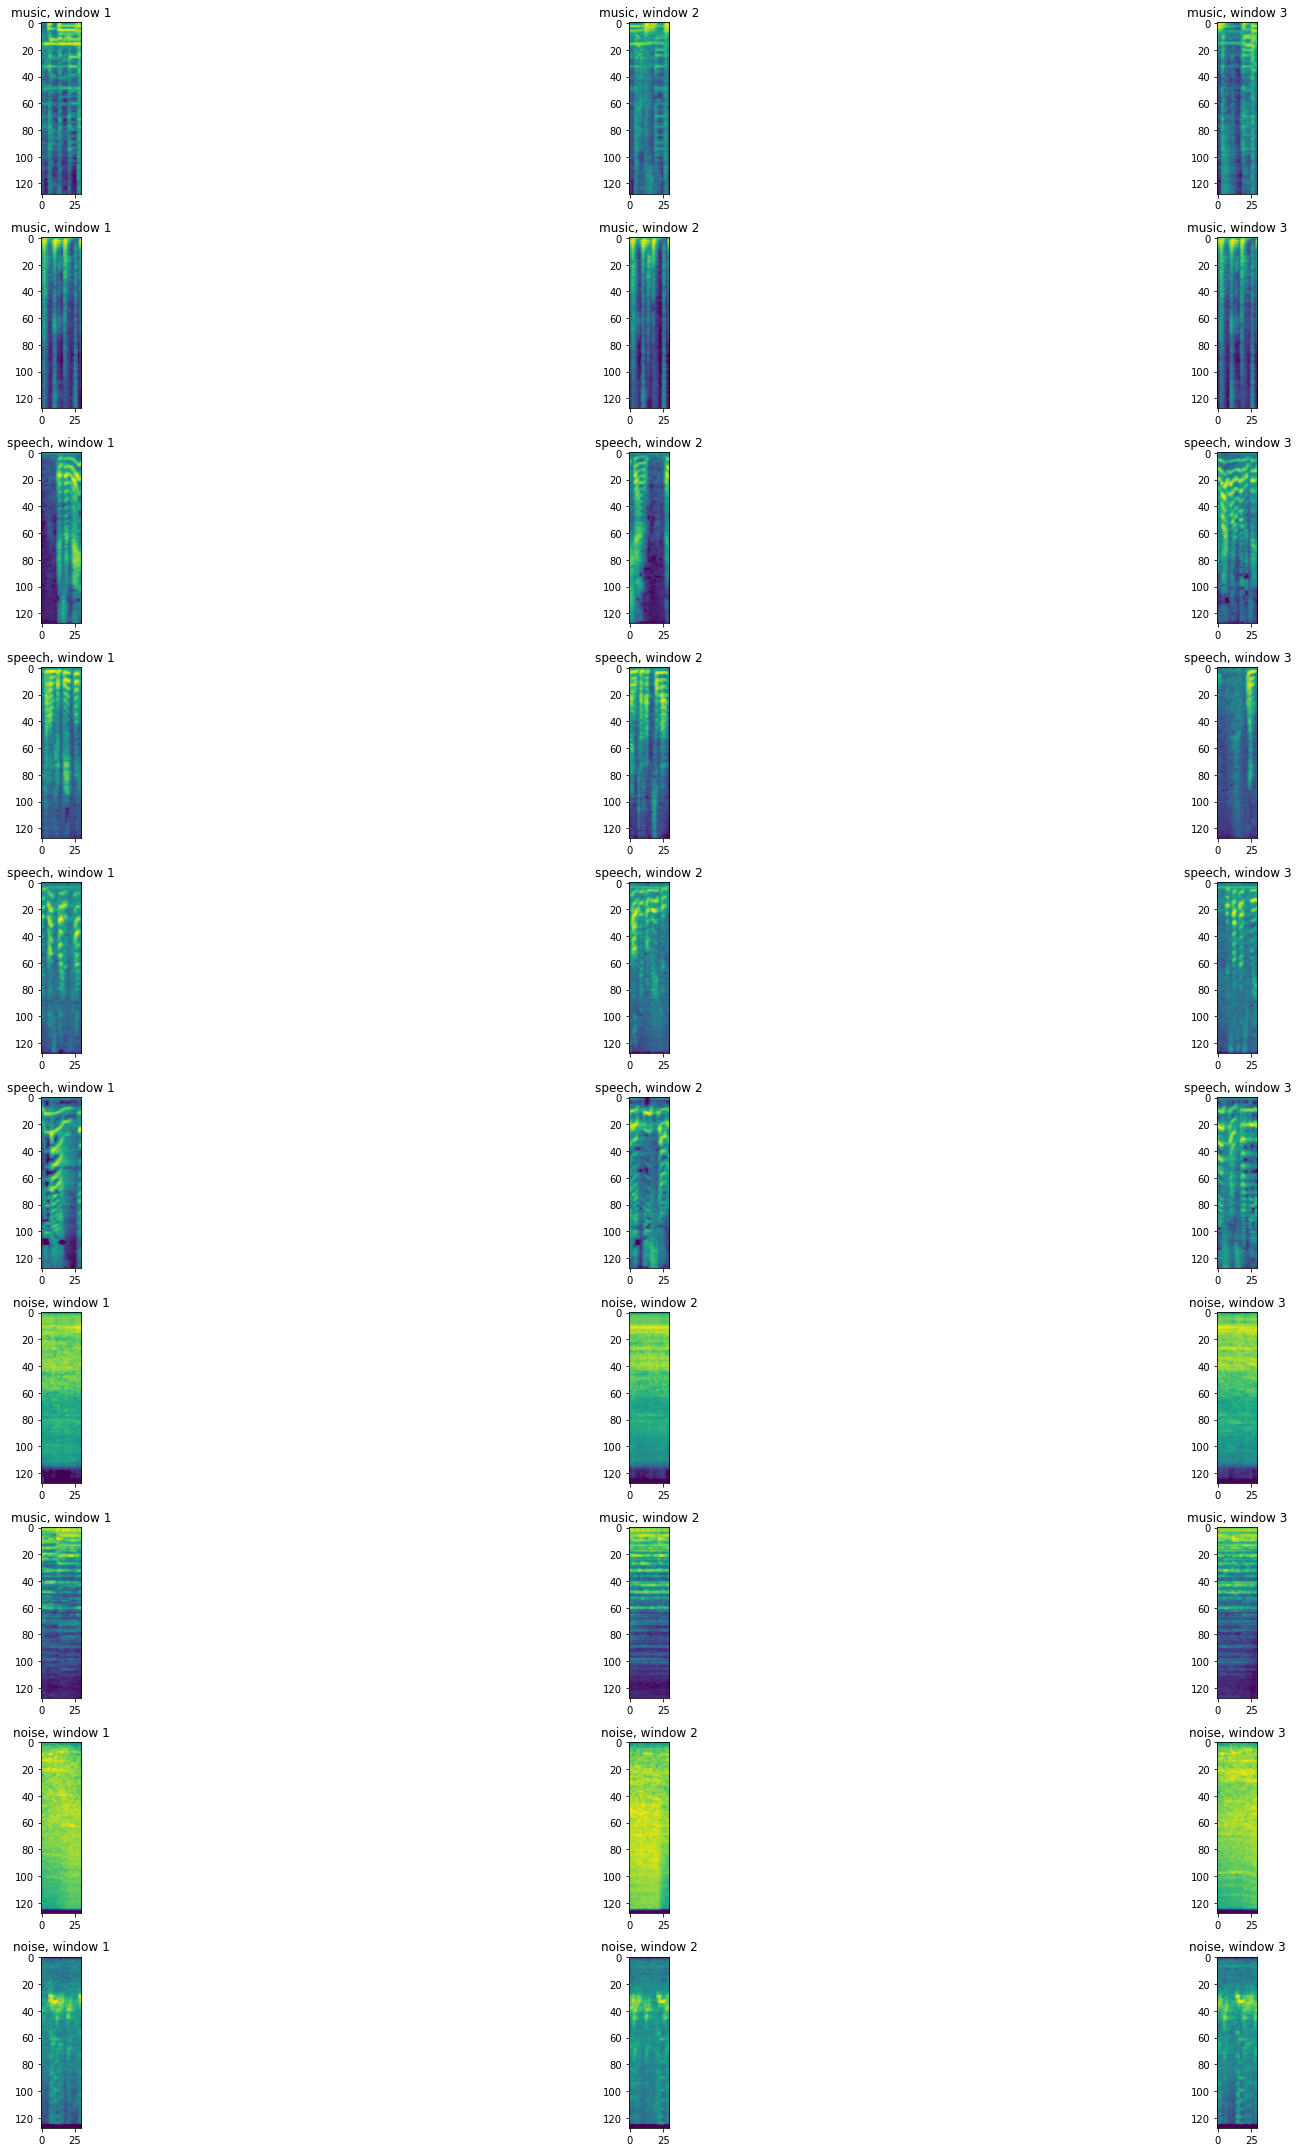

In [6]:
fig, ax = plt.subplots(10, N_CUTS, figsize=(30, 30))
for i, row in enumerate(train.sample(10).values):
    filepath, label = row[1], row[2]
    for j, window in enumerate(process_wav(ROOT_DIR, filepath)):
        ax[i, j].imshow(window.squeeze(0))
        ax[i, j].set_title(f"{label}, window {j+1}")
fig.tight_layout()
plt.show()

# Create PyTorch Datasets and DataLoaders

In [7]:
class SpecDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = [[], []]
        for filename, target in tqdm(zip(data["wav_path"], data["target"]), total=len(data)):
            target_ = torch.tensor(target).long()
            spec = process_wav(ROOT_DIR, filename, to_windows=False)
            self.data[0].append(spec)
            self.data[1].append(target_)
        
    def __getitem__(self, index):
        return self.data[0][index].to(device), self.data[1][index].to(device)
    
    def __len__(self):
        assert len(self.data[0]) == len(self.data[1])
        return len(self.data[0])
    

class WindowDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = [[], []]
        for filename, target in tqdm(zip(data["wav_path"], data["target"]), total=len(data)):
            target_ = torch.tensor(target).long()
            windows = process_wav(ROOT_DIR, filename, to_windows=True)
            for window in windows:
                self.data[0].append(window)
                self.data[1].append(target_)
        
    def __getitem__(self, index):
        return self.data[0][index].to(device), self.data[1][index].to(device)
    
    def __len__(self):
        assert len(self.data[0]) == len(self.data[1])
        return len(self.data[0])

In [8]:
train_dataset = WindowDataset(train)
validation_dataset = SpecDataset(val)

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, drop_last=False)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, drop_last=False)

In [10]:
batch_X_train, batch_y_train = next(iter(train_dataloader))
print(type(batch_X_train), batch_X_train.shape)
print(type(batch_y_train), batch_y_train.shape)

<class 'torch.Tensor'> torch.Size([32, 1, 128, 30])
<class 'torch.Tensor'> torch.Size([32])


# Define an autoencoder model to reduce the dimentionality

In [164]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, bottleneck=20):
        super(SimpleAutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(128*30, bottleneck),
            nn.ReLU(inplace=True)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, 128*30)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x.view(-1, 128, 30)
    
class ConvEncoder(nn.Module):
    def __init__(self, bottleneck=20):
        super(ConvEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(124*28, 128*30),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        x = self.encoder(x)
#         print(x.shape)
        x = self.decoder(x)
#         print(x.shape)
        return x.view(-1, 128, 30)

# Create the autoencoder

In [166]:
ae = ConvEncoder()
# net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)
# net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# net.fc = nn.Linear(in_features=512, out_features=N, bias=True)
ae = ae.to(device)
history = []
loss = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.00005)
batch_X, batch_y = next(iter(train_dataloader))
out = ae(batch_X)
print(out.shape)
ae

torch.Size([32, 128, 30])


ConvEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
    (6): Flatten()
    (7): Linear(in_features=3472, out_features=3840, bias=True)
    (8): ReLU(inplace=True)
  )
)

# Train and validate the autoencoder

In [167]:
def train_epoch(ae, train_dataloader, optimizer, loss):
    ae.train()
    loss_train = []
    
    for batch_X, _ in train_dataloader:
        batch_X = batch_X.to(device)
        out = ae(batch_X)
        train_batch_loss = loss(out, batch_X)
        
        optimizer.zero_grad()
        train_batch_loss.backward()
        optimizer.step()
        
        loss_train.append(train_batch_loss.item())

    return np.array(loss_train).mean()


def validate(ae, validation_dataloader, loss):
    ae.eval()
    loss_val = []
    
    for batch_X, _ in validation_dataloader:
        batch_size = batch_X.size(0)
        batch_X = batch_X.to(device)
        batch_windows = spec_to_windows(batch_X, batch=True)
        with torch.no_grad():
            window_losses = []
            for i, batch_window in enumerate(batch_windows):
                out = ae(batch_window)
                window_losses.append(loss(out, batch_window).item())
        batch_loss = np.array(window_losses).mean()
        
        loss_val.append(batch_loss)

    
    return np.array(loss_val).mean()

In [168]:
N_EPOCHS = 100
n_val = 2

losses_train = []
epochs_train = []
losses_val = []
accs_val = []
epochs_val = []

fig_loss = go.Figure(    
)

fig_loss.add_scatter(
    y=losses_train, x=epochs_train,
    name='train loss'
)
fig_loss.add_scatter(
    y=losses_val, x=epochs_val,
    name='validation loss'
)

fig_loss.update_layout(height=500, width=1300, title_text='AutoEncoder')
fig_loss = go.FigureWidget(fig_loss)
display(fig_loss)

if not os.path.exists("models\\tmp\\ae"):
        os.makedirs("models\\tmp\\ae")
        
for epoch in tqdm(range(N_EPOCHS)):
#     loss_train = train_epoch(net, train_dataloader, optimizer, loss)
    loss_train = train_epoch(ae, train_dataloader, optimizer, loss)
    losses_train.append(loss_train)
    epochs_train.append(epoch)
    
    if epoch % n_val == 0:
        loss_val = validate(ae, validation_dataloader, loss)
        losses_val.append(loss_val)
        epochs_val.append(epoch)
        
    fig_loss.data[0].x = epochs_train
    fig_loss.data[0].y = losses_train
    
    fig_loss.data[1].x = epochs_val
    fig_loss.data[1].y = losses_val
    
    torch.save(ae.state_dict(), f"models\\tmp\\ae\\{epoch}")

FigureWidget({
    'data': [{'name': 'train loss', 'type': 'scatter', 'uid': '50ecca48-ea8c-47d9-b983-7b459b20…

KeyboardInterrupt: 

In [259]:
ae.eval();

# Create an encoded dataloader

In [245]:
class EncodedWindowsDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = []
        for filename in tqdm(data["wav_path"], total=len(data)):
            self.data.append(filename)
        
    def __getitem__(self, index):
        return ae.encoder(process_wav(ROOT_DIR, self.data[index // N_CUTS], to_windows=True)[index % N_CUTS].unsqueeze(0).to(device))
    
    def __len__(self):
        return len(self.data)

In [274]:
encoded_train_dataset = EncodedWindowsDataset(train)
encoded_validation_dataset = EncodedWindowsDataset(val)

In [276]:
from sklearn.cluster import AgglomerativeClustering
ac = AgglomerativeClustering(3, memory="accache")
ac.fit([ae.decoder(x.to(device)).squeeze(0).cpu().detach().numpy() for x in encoded_train_dataset])

AgglomerativeClustering(memory='accache', n_clusters=3)

In [ ]:
from sklearn.cluster import SpectralClustering
ac = SpectralClustering(3)
ac.fit([ae.decoder(x.to(device)).squeeze(0).cpu().detach().numpy() for x in encoded_train_dataset])

D:\Programs\Anaconda3\envs\silero\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [ ]:
predicted = ac.fit_predict([ae.decoder(x.to(device)).squeeze(0).cpu().detach().numpy() for x in encoded_validation_dataset])

In [ ]:
pred = []
for i in range(len(predicted) // N_CUTS):
    p = torch.empty(N_CUTS)
    for j in range(N_CUTS):
        p[j] = predicted[N_CUTS*i + j]
    pred.append(torch.mode(p).values.item())

In [ ]:
from sklearn import metrics
score = metrics.adjusted_rand_score(pred, val["target"].values)

In [ ]:
score

In [288]:
ac.__dict__

{'n_clusters': 3,
 'distance_threshold': None,
 'memory': 'accache',
 'connectivity': None,
 'compute_full_tree': 'auto',
 'linkage': 'ward',
 'affinity': 'euclidean',
 'n_features_in_': 3840,
 'children_': array([[1446, 1447],
        [ 609,  610],
        [1200, 1201],
        ...,
        [4083, 4086],
        [4084, 4087],
        [4088, 4089]], dtype=int64),
 'n_connected_components_': 1,
 'n_leaves_': 2046,
 'n_clusters_': 3,
 'labels_': array([1, 1, 1, ..., 1, 1, 1], dtype=int64)}

In [30]:
N_EPOCHS = 100
n_val = 3

losses_train = []
epochs_train = []
losses_val = []
accs_val = []
epochs_val = []

fig_loss = make_subplots(
    cols=2, rows=1,
    subplot_titles=['Loss', 'Accuracy'], column_widths=[0.7, 0.3]
    
)

fig_loss.add_scatter(
    y=losses_train, x=epochs_train,
    name='train loss', row=1, col=1
)
fig_loss.add_scatter(
    y=losses_val, x=epochs_val,
    name='validation loss', row=1, col=1
)
fig_loss.add_scatter(
    y=losses_val, x=epochs_val,
    name='validation accuracy', row=1, col=2
)
fig_loss.update_layout(height=500, width=1300, title_text='')
fig_loss = go.FigureWidget(fig_loss)
display(fig_loss)

if not os.path.exists("models\\tmp"):
        os.makedirs("models\\tmp")
        
for epoch in tqdm(range(N_EPOCHS)):
#     loss_train = train_epoch(net, train_dataloader, optimizer, loss)
    loss_train = train_epoch(net, full_train_dataloader, optimizer, loss)
    losses_train.append(loss_train)
    epochs_train.append(epoch)
    
    if epoch % n_val == 0:
        acc, loss_val = validate(net, validation_dataloader, loss)
        accs_val.append(acc)
        losses_val.append(loss_val)
        epochs_val.append(epoch)
        
    fig_loss.data[0].x = epochs_train
    fig_loss.data[0].y = losses_train
    
    fig_loss.data[1].x = epochs_val
    fig_loss.data[1].y = losses_val
    
    fig_loss.data[2].x = epochs_val
    fig_loss.data[2].y = accs_val
    
    torch.save(net.state_dict(), f"models\\tmp\\{epoch}")

FigureWidget({
    'data': [{'name': 'train loss',
              'type': 'scatter',
              'uid': 'd2e6…

KeyboardInterrupt: 

# Make submission

In [249]:
submit_features = pd.read_csv('sample_submission.csv')
submit_features.head()

,wav_path,target
0,val/e/b7cf2c4.wav,0
1,val/0/8f1489d.wav,0
2,val/f/14b7304.wav,0
3,val/2/3763132.wav,0
4,val/0/51c4271.wav,0


In [362]:
class SubmissionDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = []
        for filename in tqdm(data["wav_path"], total=len(data)):
            self.data.append(filename)
        
    def __getitem__(self, index):
        return process_wav(ROOT_DIR, self.data[index], to_windows=False), self.data[index]
    
    def __len__(self):
        return len(self.data)

In [363]:
submission_dataset = SubmissionDataset(submit_features)
submission_dataloader = torch.utils.data.DataLoader(submission_dataset, batch_size=32, drop_last=False, num_workers=0)

In [364]:
if input() == 'y':
    submission = pd.DataFrame(columns=['wav_path', 'target'])
    submission.to_csv('submission.csv', index=False)

 y


In [365]:
net.eval()
for batch_X, batch_wav_path in tqdm(submission_dataloader):
    batch_size = batch_X.size(0)
    batch_X = batch_X.to(device)
    with torch.no_grad():
        batch_windows = spec_to_windows(batch_X, batch=True)
        batch_y_pred_windows = torch.empty(N_CUTS, batch_size).to(device)
        for i, batch_window in enumerate(batch_windows):
            out = net(batch_window)
            batch_y_pred_windows[i] = out.argmax(axis=1)
        batch_y_pred = torch.mode(batch_y_pred_windows, axis=0).values.cpu().numpy().astype(int)
        batch_submission = pd.DataFrame({'wav_path': batch_wav_path, 'target': batch_y_pred})
        batch_submission.to_csv('submission.csv', mode='a', index=False, header=False)

In [224]:
pd.read_csv('submission.csv')

,wav_path,target
0,val/e/b7cf2c4.wav,2
1,val/0/8f1489d.wav,2
2,val/f/14b7304.wav,0
3,val/2/3763132.wav,0
4,val/0/51c4271.wav,1
...,...,...
55195,val/1/0564de3.wav,0
55196,val/8/35d87ad.wav,2
55197,val/f/6135083.wav,1
55198,val/6/2a6a3ad.wav,0
